# Proyecto 1
### Explorando los Algoritmos de Aprendizaje Supervisado

Estudiantes: 

Carlos Adrián Araya Ramírez---------2018319701

Michael Shakime Richards Sparks----2018170667

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import seaborn as sns


from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import roc_curve, auc

from ourmodels.LogisticRegression import LogisticRegression as OurLogisticRegression
from ourmodels.DecisionTree import DecisionTreeClassifier as OurDecisionTree
from ourmodels.KNearestNeighbors import KNearestNeighbors as OurKNearestNeighbors


# 1. ANÁLISIS DE DATOS

In [234]:
# Load the winequality-red dataset
df = pd.read_csv("datasets/winequality-red.csv")
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<Axes: >

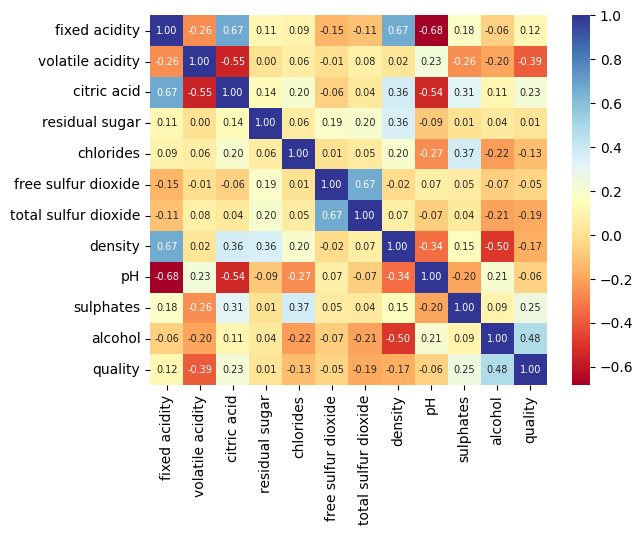

In [235]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu', annot_kws={"fontsize": 7},  fmt='.2f')

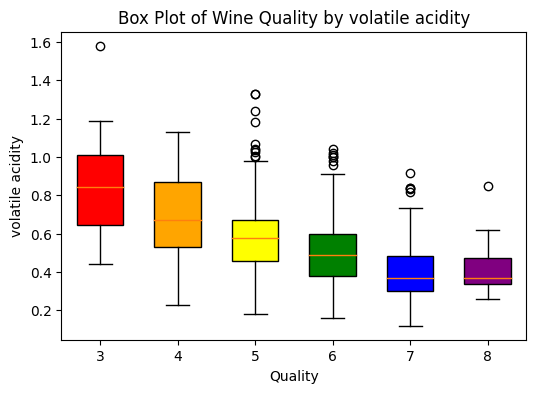

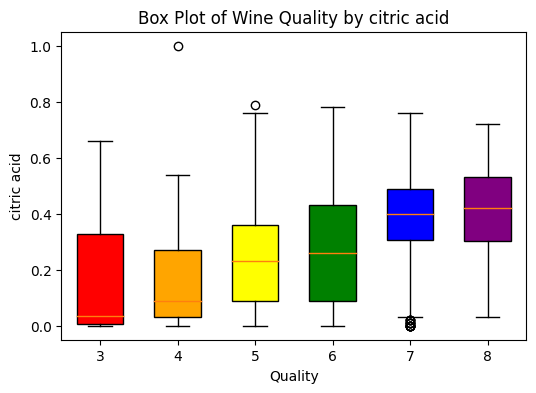

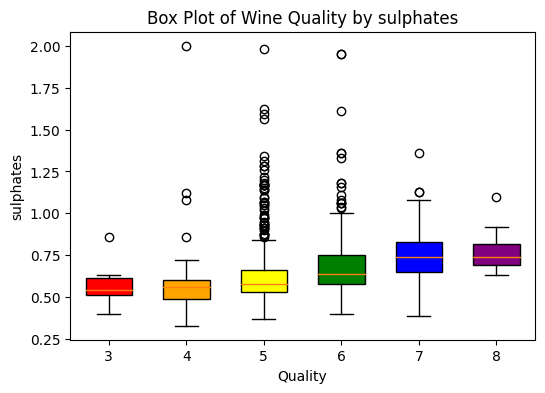

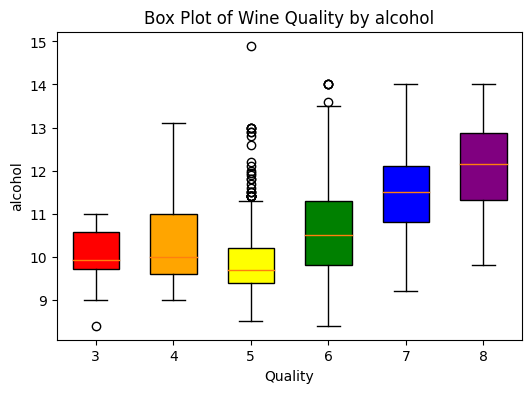

In [236]:

# Select features with correlation with "quality" greater than or equal to 0.2 or less than or equal to -0.2
selected_features = corr_matrix[abs(corr_matrix["quality"]) >= 0.2]["quality"].index.tolist()

# Remove the features that do not meet the selection criteria
df = df[selected_features]

# Get the list of features
features = df.columns[:-1]

# Define colors for each quality value
colors = {3: 'red', 4: 'orange', 5: 'yellow', 6: 'green', 7: 'blue', 8: 'purple'}

# Create a box plot for each feature
for feature in features:
    # Create a new figure and axis for each feature
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Loop through each quality value and plot the box
    for quality in sorted(df['quality'].unique()):
        box_color = colors[quality]  # Get the color for this quality value
        data = df[df['quality'] == quality][feature]  # Get the data for this quality value
        ax.boxplot(data, positions=[quality], widths=0.6, showfliers=True, patch_artist=True, boxprops=dict(facecolor=box_color))
    
    # Set the title and axis labels
    plt.title("Box Plot of Wine Quality by " + feature)
    plt.xlabel("Quality")
    plt.ylabel(feature)
    
    # Set the x-axis limits and ticks
    ax.set_xlim(2.5, 8.5)
    ax.set_xticks(range(3, 9))
    ax.set_xticklabels(range(3, 9))
    
    # Remove the grid lines
    ax.grid(False)
    
    # Show the plot
    plt.show()

# 2. FEATURE ENGINEERING

In [237]:
""" Remove outliers, this values skew the mean and standard deviation, resulting in normalization that 
is not representative of the majority of the data points. """

# Get the interquartile range for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Get the lower and upper bounds for each column
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Get the mean for each feature in the IQR
IQR_mean = (Q1 + Q3) / 2

# Replace the values that are outside the interquartile range with the mean of the feature in the IQR
df_iqr = df.where((df >= lower) & (df <= upper), other=IQR_mean, axis=1)
features_names = df_iqr.columns.to_list()

# # Replace the values that are outside the interquartile range with the respective bound
# df_iqr = df.clip(lower=lower, upper=upper, axis=1)

# # Remove the values that are outside the interquartile range
# df_iqr = df[(df >= lower) & (df <= upper)].dropna()

""" Normalize using MinMaxScaler method. """

# Create a copy of the dataframe without the quality feature
df_to_normalize = df_iqr.iloc[:, :-1]

# Initialize the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the df_to_normalize dataset
scaler.fit(df_to_normalize)

# Transform the df_without_quality dataset using the scaler
df_normalized = pd.DataFrame(scaler.transform(df_to_normalize), columns=df_to_normalize.columns)

# Add the quality feature of the original dataframe to the normalized dataframe
df_normalized['quality'] = df['quality']

df_normalized.head()

,volatile acidity,citric acid,sulphates,alcohol,quality
0,0.651685,0.000000,0.348485,0.196078,5
1,0.853933,0.000000,0.530303,0.274510,5
2,0.719101,0.050633,0.484848,0.274510,5
3,0.179775,0.708861,0.378788,0.274510,6
4,0.651685,0.000000,0.348485,0.196078,5


# 3. PREPROCESAMIENTO

In [238]:
# Divides the "quality" column into two categories using bins and labels.
bins = [2, 5.5, 8]
labels = ["MAL VINO", "BUEN VINO"]
df_normalized["quality"] = pd.cut(df_normalized["quality"], bins=bins, labels=labels)

# show the updated dataframe
count = df_normalized["quality"].value_counts()
print(f"Categorías:\n   BUEN VINO {count[0]}\n   MAL VINO {count[1]}\n")

# Converting the categorical labels in the "quality" column of the normalized dataset to numerical values.
lb = LabelEncoder()
df_normalized["quality"] = lb.fit_transform(df_normalized["quality"])

# Replace the labels with 0 and 1
df_normalized["quality"].replace({1: 0, 0: 1}, inplace=True)


# # Map the categorical labels in the "quality" column to numerical values.
# label_map = {"BUEN VINO": 1, "MAL VINO": 0}
# df_normalized["quality"] = df_normalized["quality"].map(label_map)

# Get the arrays
X = df_normalized.drop("quality", axis=1)
y = df_normalized["quality"]

# Cast to numpy
X = X.to_numpy()
y = y.to_numpy()

# Splits the dataset into training and testing sets using train_test_split (stratifying based on the "quality" variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=21, stratify=y)

Categorías:
   BUEN VINO 855
   MAL VINO 744




# MODELOS
Evaluar de manera objetiva 3 algoritmos de aprendizaje supervisado

### REGRESIÓN LOGÍSTICA

In [239]:
""" Find best params for the model using GridSearch """

# Define the hyperparameters to tune
param_grid = {'C': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 100]}
max_iter = 10000

# Create an instance of the logistic regression model
log_reg = LogisticRegression(max_iter=max_iter)

# Create and fit GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(log_reg, param_grid, cv=5).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)


Best parameters:  {'C': 0.2}
Best score:  0.7343661818971132


In [240]:
'''SKLEARN'''
# Create a new logistic regression model with the best parameters and make predictions
sklearn_log_reg = LogisticRegression(C=best_params['C']).fit(X_train, y_train)
y_pred_sklearn = sklearn_log_reg.predict(X_test)
# Calculate sklearn accuracy, precision and recall
sklearn_accuracy = sklearn_log_reg.score(X_test, y_test)
sklearn_precision = precision_score(y_test, y_pred_sklearn)
sklearn_recall = recall_score(y_test, y_pred_sklearn)

'''OUR MODEL'''
# Fit Our model and make predictions
our_log_reg = OurLogisticRegression(lr=best_params['C'], num_iter=max_iter)
our_log_reg.fit(X_train, y_train)
y_pred_our_model = our_log_reg.predict(X_test, 0.5)
# Calculate our model metrics
our_model_accuracy = ...
our_model_precision = our_log_reg.score(y_pred_our_model,y_test)
our_model_recall = ...

'''TABLE'''
# Create a dataframe with the metrics
metrics = {
    'Accuracy': [sklearn_accuracy, our_model_accuracy,],
    'Precision': [ sklearn_precision, our_model_precision,],
    'Recall': [sklearn_recall, our_model_recall, ],
}
pd.DataFrame.from_dict(metrics, orient='index', columns=["Sklearn's model", 'Our model', ])

,Sklearn's model,Our model
Accuracy,0.745833,Ellipsis
Precision,0.772358,0.745833
Recall,0.742188,Ellipsis


              precision    recall  f1-score   support

           0       0.72      0.75      0.73       112
           1       0.77      0.74      0.76       128

    accuracy                           0.75       240
   macro avg       0.75      0.75      0.75       240
weighted avg       0.75      0.75      0.75       240



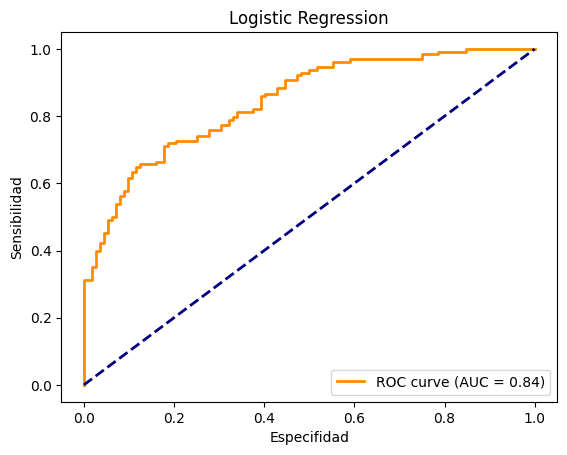

In [241]:
# Printing stats 
print(classification_report(y_test, y_pred_sklearn))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities of the positive class
y_prob_sklearn = sklearn_log_reg.predict_proba(X_test)[:, 1]

# Calculate the TPR and FPR values for different classification thresholds
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, y_prob_sklearn)

# Calculate the area under the ROC curve (AUC)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

# Plot the ROC curve
plt.plot(fpr_sklearn, tpr_sklearn, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_sklearn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Especifidad')
plt.ylabel('Sensibilidad')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.show()


### ÁRBOL


In [242]:
""" Find best params for the model using GridSearch """

# Define the parameter grid for grid search
param_grid = {'max_depth': [20, 30, 40, 50],
              'min_samples_leaf': [1, 2, 4, 8],
              'min_samples_split': [2, 4, 8, 16]}

# Create a DecisionTreeClassifier instance
tree = DecisionTreeClassifier()

# Create and fit a GridSearchCV instance
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)


Best parameters:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best score:  0.7262670935532884


In [243]:
'''SKLEARN'''
# Create a new decision tree model with the best parameters and make predictions
sklearn_tree = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf']).fit(X_train, y_train)
y_pred_sklearn = sklearn_tree.predict(X_test)
# Calculate sklearn accuracy, precision and recall
sklearn_accuracy = sklearn_tree.score(X_test, y_test)
sklearn_precision = precision_score(y_test, y_pred_sklearn)
sklearn_recall = recall_score(y_test, y_pred_sklearn)

sklearn_recall = recall_score(y_test, y_pred_sklearn)

'''OUR MODEL'''
# Fit Our model and make predictions
# our_tree = OurDecisionTree(max_depth=best_params['max_depth'])
# our_tree.fit(features_names, X_train, y_train)
# y_pred_our_model = our_tree.predict(X_test)
# Calculate our model metrics
our_model_accuracy = ...
our_model_precision = ...#our_tree.score(y_pred_our_model,y_test)
our_model_recall = ...

'''TABLE'''
# Create a dataframe with the metrics
metrics = {
    'Accuracy': [sklearn_accuracy, our_model_accuracy,],
    'Precision': [ sklearn_precision, our_model_precision,],
    'Recall': [sklearn_recall, our_model_recall, ],
}
pd.DataFrame.from_dict(metrics, orient='index', columns=["Sklearn's model", 'Our model', ])


,Sklearn's model,Our model
Accuracy,0.766667,Ellipsis
Precision,0.781250,Ellipsis
Recall,0.781250,Ellipsis


              precision    recall  f1-score   support

           0       0.75      0.75      0.75       112
           1       0.78      0.78      0.78       128

    accuracy                           0.77       240
   macro avg       0.77      0.77      0.77       240
weighted avg       0.77      0.77      0.77       240



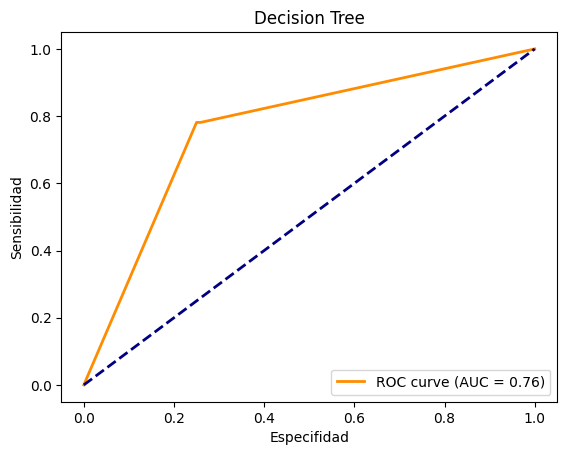

In [244]:
# Printing stats 
print(classification_report(y_test, y_pred_sklearn))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities of the positive class
y_prob_sklearn = sklearn_tree.predict_proba(X_test)[:, 1]

# Calculate the TPR and FPR values for different classification thresholds
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, y_prob_sklearn)

# Calculate the area under the ROC curve (AUC)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

# Plot the ROC curve
plt.plot(fpr_sklearn, tpr_sklearn, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_sklearn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Especifidad')
plt.ylabel('Sensibilidad')
plt.title('Decision Tree')
plt.legend(loc="lower right")
plt.show()


## KNN

In [245]:
""" Find best params for the model using GridSearch """

# Define the parameter grid for grid search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17], 'weights': ['uniform', 'distance']}

# Create a KNeighborsClassifier instance
knn = KNeighborsClassifier()

# Create and fit a GridSearchCV instance
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

Best parameters:  {'n_neighbors': 17, 'weights': 'distance'}
Best score:  0.7785028217929238


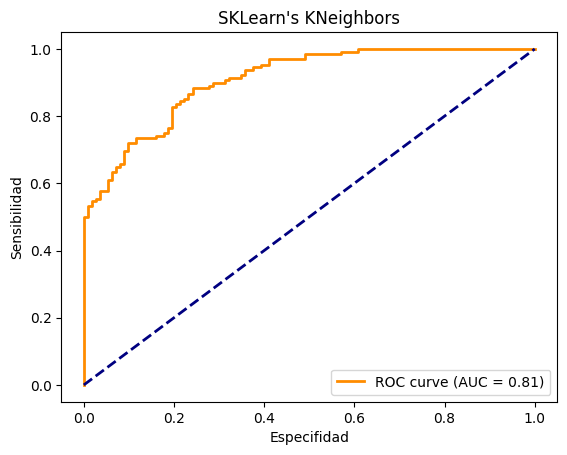

,Sklearn's model,Our model
Accuracy,0.812500,0.754167
Precision,0.821705,0.780488
Recall,0.828125,0.750000
AUC,0.811384,0.754464


In [246]:
from sklearn.metrics import roc_curve, auc

'''SKLEARN'''
# Create a new knn model with the best parameters and make predictions
sklearn_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights']).fit(X_train, y_train)
y_pred_sklearn = sklearn_knn.predict(X_test)
# Calculate sklearn accuracy, precision and recall
sklearn_accuracy = sklearn_knn.score(X_test, y_test)
sklearn_precision = precision_score(y_test, y_pred_sklearn)
sklearn_recall = recall_score(y_test, y_pred_sklearn)
sklearn_auc = roc_auc_score(y_test, y_pred_sklearn)

'''OUR MODEL'''
# Fit Our model and make predictions
our_tree = OurKNearestNeighbors(X_train, y_train, n_neighbors=best_params['n_neighbors'])
# Calculate our model metrics
our_model_accuracy, y_pred_our_model, y_test = our_tree.score(X_test, y_test)
our_model_precision = precision_score(y_test, y_pred_our_model)
our_model_recall = recall_score(y_test, y_pred_our_model)
our_model_auc = roc_auc_score(y_test, y_pred_our_model)

'''CHART'''
# Get the probabilities of the positive class
y_prob_sklearn = sklearn_knn.predict_proba(X_test)[:, 1]
# Calculate the TPR and FPR values for different classification thresholds
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, y_prob_sklearn)
# Plot the ROC curve
plt.plot(fpr_sklearn, tpr_sklearn, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % sklearn_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Especifidad')
plt.ylabel('Sensibilidad')
plt.title('SKLearn\'s KNeighbors')
plt.legend(loc="lower right")
plt.show()

'''TABLE'''
# Create a dataframe with the metrics
metrics = {
    'Accuracy': [sklearn_accuracy, our_model_accuracy,],
    'Precision': [ sklearn_precision, our_model_precision,],
    'Recall': [sklearn_recall, our_model_recall, ],
    'AUC': [sklearn_auc, our_model_auc, ]
}
pd.DataFrame.from_dict(metrics, orient='index', columns=["Sklearn's model", 'Our model', ])